In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm

from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

import warnings
import os
import sys
warnings.filterwarnings("ignore")


In [2]:
#--- iSpec directory -------------------------------------------------------------
# ispec_dir = os.path.dirname(os.path.realpath(__file__)) + "/"
ispec_dir = '/Users/daniel/iSpec/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec

In [3]:

import logging
LOG_LEVEL = "error"
logger = logging.getLogger() # root logger, common for all
logger.setLevel(logging.getLevelName(LOG_LEVEL.upper()))

In [4]:
# plt.style.use('notebook')
spectra_dir = 'data/Spectra/SONG/'

In [5]:
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

def smooth(x, y, factor=0.1):
    df = x[1] - x[0]
    return gaussian_filter(y, factor / df)

def flatten(x, y, return_trend=False):
    m = y < np.percentile(y, 95)
    p = np.polyfit(x[m], y[m], 3)
    if return_trend:
        return y / np.polyval(p, x), np.polyval(p, x)
    return y / np.polyval(p, x)

def interpolate_spectrum(x, y, template_wav):
    f1  = interpolate.interp1d(x, y, kind = 'linear')
    return f1(template_wav)
    
def estimate_background(x, y, log_width=0.01):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

def fit_continuum(x, y, ivars, order=6, nsigma=[0.3,3.0], maxniter=50):
    """Fit the continuum using sigma clipping
    Args:
        x: The wavelengths
        y: The log-fluxes
        order: The polynomial order to use
        nsigma: The sigma clipping threshold: tuple (low, high)
        maxniter: The maximum number of iterations to do
    Returns:
        The value of the continuum at the wavelengths in x
    """
    A = np.vander(x - np.nanmean(x), order+1)
    m = np.ones(len(x), dtype=bool)
    for i in range(maxniter):
        m[ivars == 0] = 0  # mask out the bad pixels
        w = np.linalg.solve(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
        mu = np.dot(A, w)
        resid = y - mu
        sigma = np.sqrt(np.nanmedian(resid**2))
        #m_new = np.abs(resid) < nsigma*sigma
        m_new = (resid > -nsigma[0]*sigma) & (resid < nsigma[1]*sigma)
        if m.sum() == m_new.sum():
            m = m_new
            break
        m = m_new
    return mu


def flatten(x, y):
    m = y < np.percentile(y, 95)
    p = np.polyfit(x[m], y[m], 3)
    return y / np.polyval(p, x)

In [6]:
def get_spectrum(spec, orders):
    spec_data = pf.getdata(spec)
    wav = spec_data[3,:,:]
    flux = spec_data[0,:,:]# / spec_data[2,:,:]
    
    all_wav, all_flux = [], []
    for w, f in zip(wav[orders], flux[orders]):
        ivars = np.ones_like(w)
        mu = fit_continuum(w, f, ivars, order=10)
        f /= mu
#         f = flatten(w, f)
#         f = smooth(w, f)
        all_wav.extend(w)
        all_flux.extend(f)

    all_wav, all_flux = np.array(all_wav), np.array(all_flux)
    all_flux /= np.median(all_flux)
#     all_flux = smooth(all_wav, all_flux, factor=0.1)
    return all_wav, all_flux

In [7]:
def rv_ccf_mask(spectrum, diagnose=False, ax=None):
#     mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.F0.360_698nm/mask.lst"
    mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.A0.350_1095nm/mask.lst"
    ccf_mask = ispec.read_cross_correlation_mask(mask_file)

    models, ccf = ispec.cross_correlate_with_mask(spectrum, ccf_mask, \
                            lower_velocity_limit=-200, upper_velocity_limit=200, \
                            velocity_step=1.0, mask_depth=0.1, mask_size=2.0, 
                            fourier=False, only_one_peak=True)
    
    if diagnose:
        if ax is None:
            fig, ax = plt.subplots()
        plt.plot(ccf['x'], ccf['y'], lw=1, color='b', linestyle='-', marker='', markersize=1, markeredgewidth=0, markerfacecolor='b', zorder=1)
        plt.fill_between(ccf['x'], ccf['y']+ccf['err'], ccf['y']-ccf['err'], color='#CCCCCC')
        for model in models:
            plt.plot(ccf['x'], model(ccf['x']), lw=1, color='r', linestyle='-', marker='', markersize=1, markeredgewidth=0, markerfacecolor='r', zorder=2)
        plt.show()
#     if len(models) > 1:
#         return models[0].mu(), models[1].mu()#, models[1].mu(), models[1].emu()
    return models[0].mu(), models[0].emu()

## Clean spectra

In [8]:
all_spectra_files = np.array(sorted(glob.glob(spectra_dir + '*.fits')))
epochs = np.arange(len(all_spectra_files))
m = ~((epochs == 60) | (epochs == 15))
all_spectra_files = all_spectra_files[m]

orders = [18,19,20,21,22,23,24,25,26]
# orders=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
#18,19,20,21,22,23,24,25,

all_rv, all_rv_err = [], []
times = []
all_spectra = []


for spec in tqdm.tqdm(all_spectra_files[:]):

    wav, flux = get_spectrum(spec, orders)
    meta = pf.getheader( spec )
    times.append(meta['BJD-MID'])
    
    m = wav < 5500
    wav, flux = wav[m], flux[m]
    flux /= np.median(flux)
    
#     np.savetxt(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt", list(zip(wav / 10, flux, np.ones_like(flux) * 0.01)))
#     star_spectrum = ispec.read_spectrum(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt")
    star_spectrum = ispec.create_spectrum_structure(wav / 10)
    star_spectrum['flux'] = flux
    
    all_spectra.append(star_spectrum)

100%|██████████| 59/59 [00:04<00:00, 12.59it/s]


# Resample

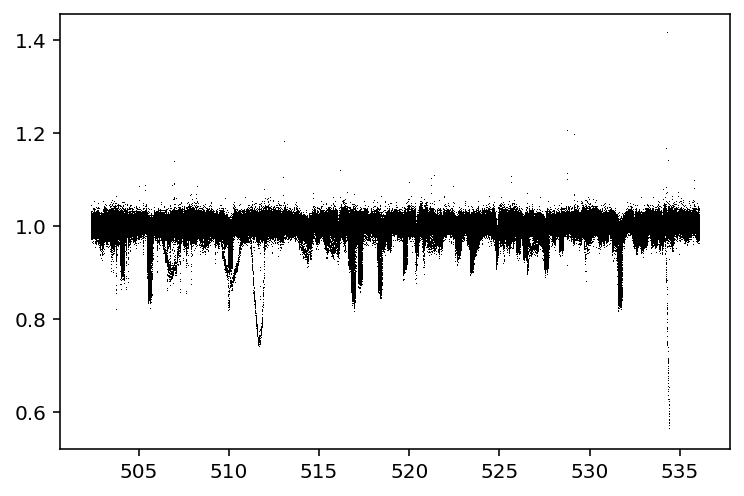

In [9]:
wavelengths = np.arange(all_spectra[0]['waveobs'].min()+3, all_spectra[0]['waveobs'].max()-3, 0.002) # 0.2 A
resampled = np.array([interpolate_spectrum(spec['waveobs'], spec['flux'], wavelengths) for spec in all_spectra])
plt.plot(wavelengths, resampled.T, ',k');

# Cross correlate with self

In [10]:
from scipy.optimize import minimize

def model(theta, x):
    a, d, x0 = theta
    gaussian = a*np.exp(-(x-x0)**2/(2*d**2)) + 0#c
    return gaussian

def func(theta, x, y):
    gaussian = model(theta, x)
    return 0.5*np.sum((y-gaussian)**2)#/sigma2 + np.log(sigma2))

def fit_gaussian(x, y, x0):
    res = minimize(func, x0, args=(x, y), 
#                    method='Nelder-Mead'
                  )
    return res

In [11]:
template = resampled[0]
all_wav_shifts = []
wav_shift_prev = 0

for i in range(20):
#     plt.figure(figsize=[7,10])
    wav_shift_primary = []
    wav_shift_uncertainty = []
    
    all_lags = []
    all_acors = []
    
    for i, spec in enumerate(resampled):
        acor = np.correlate(template - 1., spec - 1., mode='full')
#         acor /= np.max(acor)
        df = wavelengths[1] - wavelengths[0]
        lags = df*np.arange(-len(acor)//2, len(acor)//2) - wav_shift_prev

        # Fit gaussians
        m = (lags < 0.2) & (lags > -0.2)
        x0 = [np.max(acor[m]), 0.05, lags[m][np.argmax(acor[m])]]
        res = fit_gaussian(lags[m], acor[m], x0)
        wav_shift_primary.append(res.x[2])
        wav_shift_uncertainty.append(np.sqrt(np.diag(res.hess_inv))[-1])
        
        
        all_lags.append(lags[m])
        all_acors.append(acor[m])
        # Plot
#         plt.plot(lags, acor - i*0.5, c='C0', alpha=0.5)
#         plt.plot(lags, model(res.x, lags) - i*0.5, c='red', lw=0.7)
#         plt.xlim(-0.15, 0.15)
#     plt.show()

    temp_array = np.array([interpolate_spectrum(spec['waveobs'] + shift, spec['flux'], wavelengths) for spec, shift in 
                          zip(all_spectra, wav_shift_primary)])
    template = np.median(temp_array, axis=0)
    wav_shift_prev = wav_shift_primary[0]
    
    all_wav_shifts.append(wav_shift_primary)

In [12]:
np.all(np.diff(all_wav_shifts, axis=0)[-1] < 1e-9)

True

<ErrorbarContainer object of 3 artists>

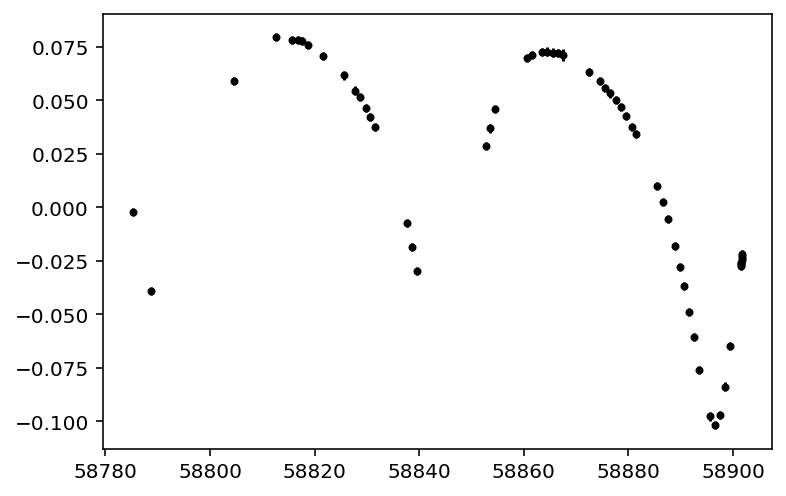

In [13]:
plt.errorbar(times, wav_shift_primary, yerr=wav_shift_uncertainty, fmt='.k')

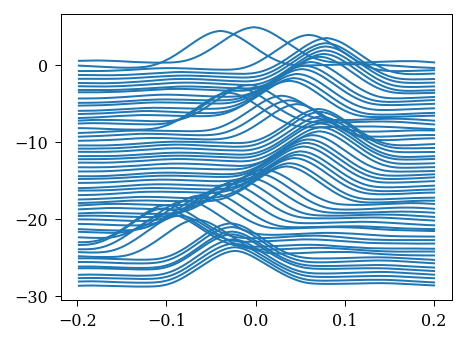

In [14]:
with plt.style.context('science'):
    for i in range(len(all_lags)):
        plt.plot(all_lags[i], all_acors[i] - i*0.5, c='C0')

# Cross correlate with atomic linelist to get absolute RVs

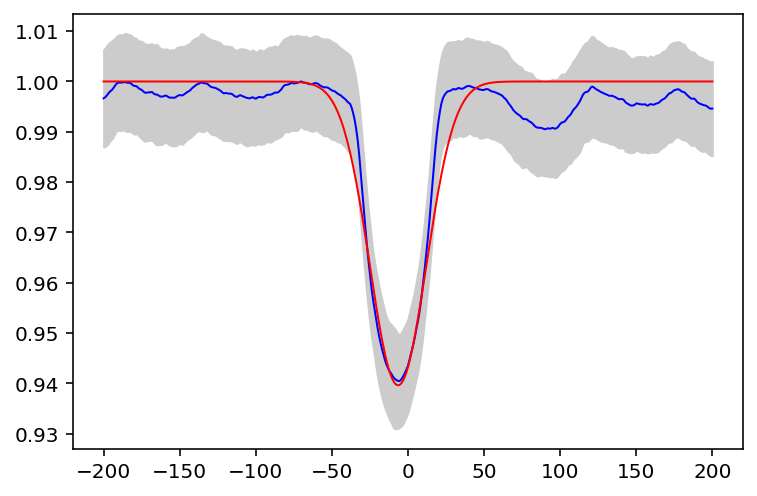

In [15]:
template_spectrum = ispec.create_spectrum_structure(wavelengths)
template_spectrum['flux'] = np.median(temp_array, axis=0)
template_spectrum['err'] = np.std(temp_array, axis=0)

rv_offset, rv_offset_err = rv_ccf_mask(template_spectrum, diagnose=True)

# Convert to radial velocities

In [16]:
import astropy.units as u

bvcs = [pf.getheader( spec )['BVC'] for spec in all_spectra_files]

RV = -1*(299792.458) * ((np.array(wav_shift_primary)) / ((wavelengths.min() + wavelengths.max()) / 2)) + rv_offset
RV = RV + bvcs + RV * bvcs / 299792.458
# RV_err = RV * wav_shift_uncertainty / wav_shift_primary
RV_err = np.abs((299792.458) * ((np.array(wav_shift_uncertainty)) / ((wavelengths.min() + wavelengths.max()) / 2)))

#     RV -= np.average(RV)

<ErrorbarContainer object of 3 artists>

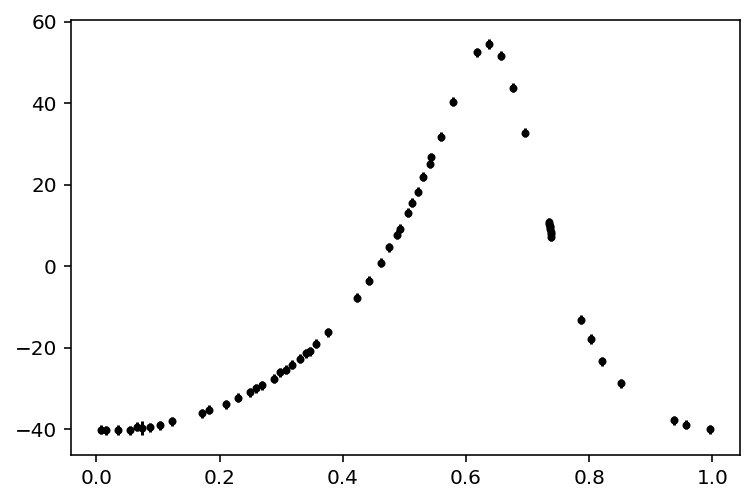

In [17]:
porb = 51.4213

plt.errorbar((np.array(times) + 2400000) % porb / porb, RV, yerr=RV_err, fmt='.k')
# plt.xlim(0.6, 0.8)
# bischoff_x, bischoff_y = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt', usecols=(0,1)).T
# plt.plot((bischoff_x + 2457000) % porb / porb, bischoff_y, '.')

In [18]:
RV_err

array([1.10504626, 1.09112065, 1.08767836, 1.07981827, 1.10074306,
       1.08554299, 1.08374785, 1.0842907 , 1.09789815, 1.08905543,
       1.09481508, 1.09777345, 1.0968263 , 1.09385739, 1.08575091,
       1.08869034, 1.09213798, 1.0927696 , 1.0916081 , 1.13623035,
       1.09020546, 1.09850633, 1.08384017, 1.10835324, 1.09908605,
       1.22203776, 1.09833913, 1.66100703, 1.09448926, 1.08597992,
       1.10053385, 1.09403583, 1.10434536, 1.0920102 , 1.0957775 ,
       1.09580233, 1.09117345, 1.10236094, 1.0845782 , 1.11216481,
       1.07197092, 1.08960938, 1.08919962, 1.07575639, 1.11423505,
       1.09233888, 1.11821063, 1.11782889, 1.12712111, 1.10274563,
       1.09526191, 1.08397816, 1.08449346, 1.10215586, 1.11557312,
       1.11650594, 1.14316156, 1.14295091, 1.14947149])

In [39]:
np.savetxt('data/RV/SONG.txt', list(zip(np.array(times), RV, RV_err)))
np.savetxt('data/RV/wav_shifts.txt', list(zip(wav_shift_primary, wav_shift_uncertainty)))

# Final corrected stacked spectrum

In [125]:
corr = np.copy(template_spectrum)
corr = ispec.correct_velocity(corr, rv_offset)

(505.0, 507.0)

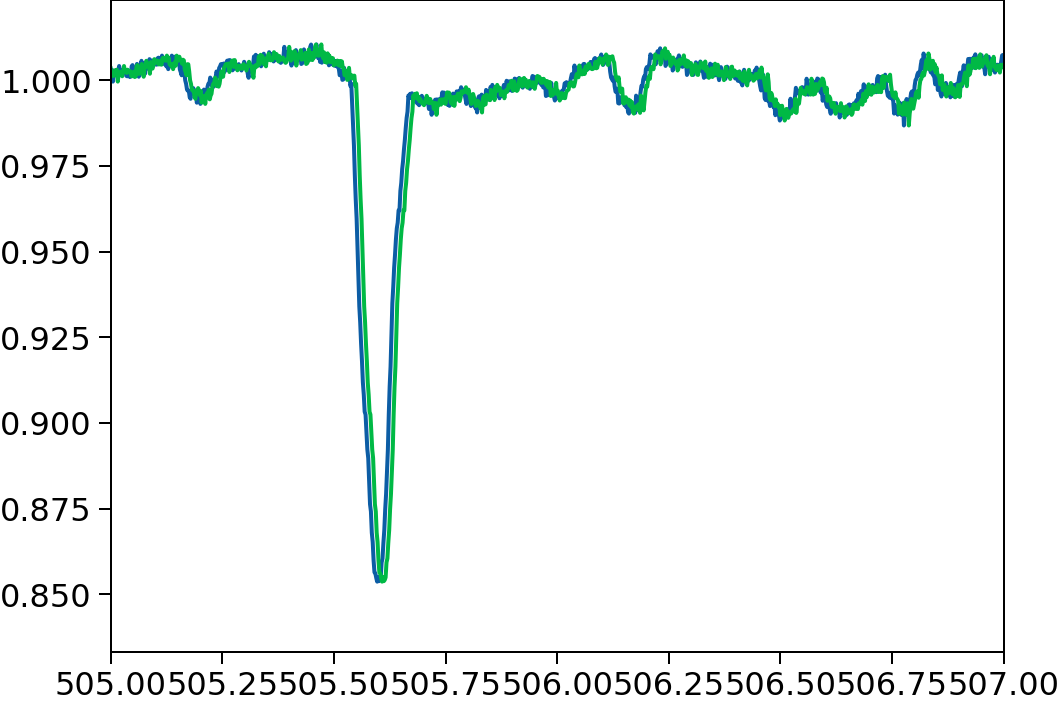

In [126]:
bkg = estimate_background(wavelengths, template, log_width=0.00015)
plt.plot(wavelengths, template)
plt.plot(corr['waveobs'], corr['flux'])
plt.xlim(505, 507)

# plt.plot(wavelengths, bkg)
# plt.xlim(505, 510)

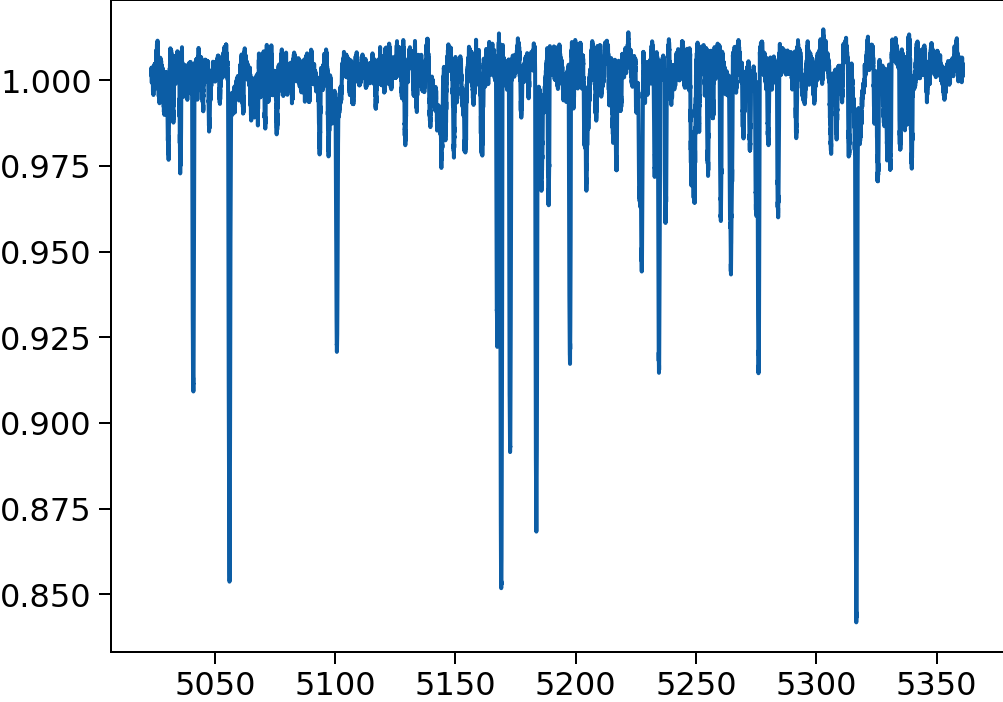

In [127]:
plt.plot(corr['waveobs'] * 10, corr['flux'])
plt.xlim(505, 507)

In [45]:
np.savetxt('data/Spectra/primary_stacked.txt', corr)

In [19]:
all_lags = np.array(all_lags)
all_acors = np.array(all_acors)

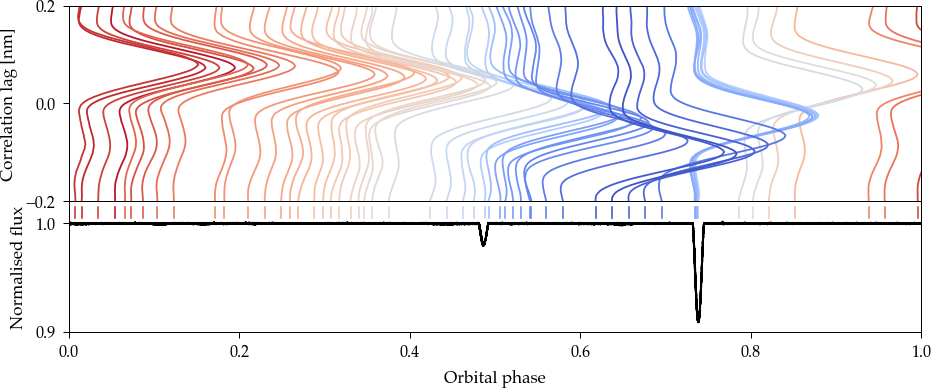

In [124]:
import seaborn as sns
colors = np.array(sns.color_palette('coolwarm_r', n_colors=len(RV)))
# colors = np.array(sns.color_palette('bwr_r', n_colors=len(RV)))


with plt.style.context('science'):
    t, y, yerr = np.loadtxt('data/photometry/tess_corrected.txt', usecols=(0,1,2)).T
    fig, axes = plt.subplots(2,1, figsize=[7.64, 3.], gridspec_kw={'height_ratios':[0.6,0.4]})

    tjd_0 = 2457000
    t += tjd_0

    porb = 51.4213
    t0 = 1696.0194

    ax = axes[1]
    fold = t % porb / porb
    sort = np.argsort(fold)
    ax.plot(fold[sort],y[sort], c='k')

    ax.set_xlim(0,1)
    ax.set_ylim(0.90, 1.02)
    ax.set_xlabel('Orbital phase')
    ax.set_ylabel('Normalised flux')

    ax = axes[0]

    rv_sort = np.argsort(RV)
    for i in range(len(np.array(all_lags))):
        c_phase = (np.array(times)[rv_sort][i] + 2400000) % porb / porb
        axes[1].plot([c_phase, c_phase], [1.015, 1.005], linewidth=0.8, alpha=1., color=colors[i])
        normed = (all_acors[rv_sort][i] / np.max(all_acors[rv_sort][i])) * 0.15
        ax.plot(normed - normed[0] + c_phase, all_lags[rv_sort][i], color=colors[i], lw=0.9)

    ax.set_xlim(0, 1)
    ax.set_ylim(-0.2, 0.2)
    ax.set_ylabel('Correlation lag [nm]')
    ax.set_xticks([])

    plt.subplots_adjust(hspace=0.)


overleaf_path = '/Users/daniel/Dropbox (Sydney Uni)/Apps/Overleaf/adra/figs/'
plt.savefig(overleaf_path+'rv_ccf.pdf', dpi=300, bbox_inches='tight')

## Create primary template by shifting and stacking

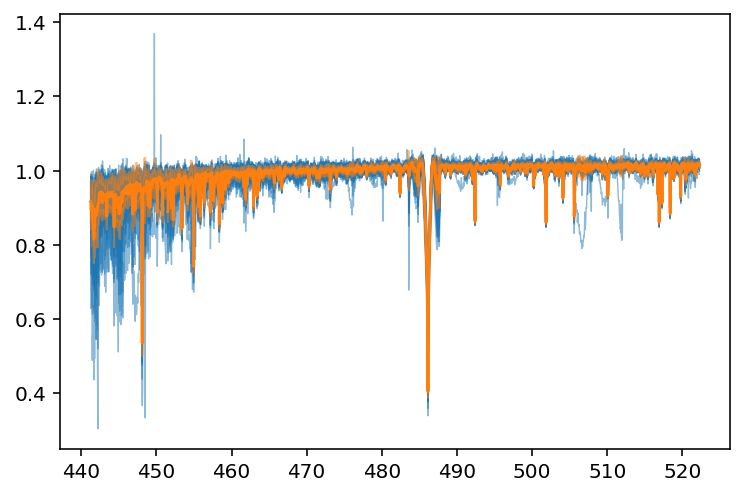

In [76]:
corr_spectra = []
# wavelengths = np.linspace(star_spectrum['waveobs'].min()+1, star_spectrum['waveobs'].max()-1, 6142)
wavelengths = np.arange(star_spectrum['waveobs'].min()+3, star_spectrum['waveobs'].max()-3, 0.002) # 0.2 A
wavelengths = np.arange(star_spectrum['waveobs'].min()+3, star_spectrum['waveobs'].max()-3, 0.035)

# 78895
coadded_spectrum = ispec.create_spectrum_structure(wavelengths)

for spectra, rv in zip(all_spectra, all_rv):
    corr = np.copy(spectra)
    corr = ispec.correct_velocity(corr, rv)
    
    corr = ispec.resample_spectrum(corr, wavelengths, zero_edges=True)
    corr_spectra.append(corr)
    plt.plot(corr['waveobs'], corr['flux'], alpha=0.5, c='C0', lw=0.7)

corr_spectra = np.array(corr_spectra)
coadded_spectrum['flux'] = np.median(corr_spectra['flux'], axis=0)
coadded_spectrum['err'] = np.std(corr_spectra['flux'], axis=0)

plt.plot(coadded_spectrum['waveobs'], coadded_spectrum['flux'], c='C1')
plt.fill_between(coadded_spectrum['waveobs'], coadded_spectrum['flux'] - coadded_spectrum['err'], coadded_spectrum['flux'] + coadded_spectrum['err'], color='C1', alpha=0.5, zorder=50)